In [1]:
import sys
sys.path.append('../mlai_research/')
import log
import utils
import cv2
import rasterio
import rasterio.plot
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
from shapely.geometry import box, mapping
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
from PIL import Image

In [3]:
logger = log.get_logger(__name__)

In [4]:
def load_data(conf):
    imgs = {}
    # 10 bands of Advanced Camera image (multispectral)
    # 3 bands of Normal Camera image
    # 1 band of Digital Surface Model
    # 1 band of Digital Terrain Model
    imgs["hyps"] = utils.load_raster(f"{conf.data.path_base_hyps}{conf.data.fn_hyps}")
    imgs["rgba"] = utils.load_raster(f"{conf.data.path_base_rgba}{conf.data.fn_rgba}")
    imgs["dsm"] = utils.load_raster(f"{conf.data.path_base_dsm}{conf.data.fn_dsm}")
    imgs["dtm"] = utils.load_raster(f"{conf.data.path_base_dtm}{conf.data.fn_dtm}")
    # Load shapefile
    gdf = gpd.read_file(f"{conf.data.path_base_points}{conf.data.fn_shp_combined}")
    return imgs, gdf


def get_bbox(imgs: dict):
    box1 = box(*imgs["hyps"].bounds)
    box2 = box(*imgs["rgba"].bounds)
    box3 = box(*imgs["dsm"].bounds)
    box4 = box(*imgs["dtm"].bounds)

    intersect = box1.intersection(box2)
    intersect = intersect.intersection(box3)
    intersect = intersect.intersection(box4)
    return intersect


def clip_raster_to_bounds(name, path_int, raster, target_bounds):
    # Create a polygon from the target bounds
    target_polygon = box(*target_bounds)

    # Clip the raster using the target polygon
    clipped_data, clipped_transform = mask(raster, [target_polygon], crop=True)

    # Update the raster metadata
    clipped_meta = raster.meta.copy()
    clipped_meta.update({
        'transform': clipped_transform,
        'height': clipped_data.shape[1],
        'width': clipped_data.shape[2]
    })

    # Create a new raster dataset with the clipped data and metadata
    with rasterio.open(f"{path_int}{name}.tif", "w", **clipped_meta) as dst:
        dst.write(clipped_data)

    # Return the clipped raster dataset
    clipped_raster = rasterio.open(f"{path_int}{name}.tif")
    logger.info(f"{clipped_raster.transform}")
    return clipped_raster


def align_rasters(name, path_int, src_raster, ref_raster):
    profile = ref_raster.profile.copy()
    aligned_data = []

    for i in range(1, src_raster.count + 1):
        src_data = src_raster.read(i)
        ref_data = np.empty((ref_raster.height, ref_raster.width), dtype=src_data.dtype)
        reproject(
            src_data,
            ref_data,
            src_transform=src_raster.transform,
            src_crs=src_raster.crs,
            dst_transform=ref_raster.transform,
            dst_crs=ref_raster.crs,
            resampling=Resampling.nearest
        )
        aligned_data.append(ref_data)

    profile.update(count=len(aligned_data))

    with rasterio.open(f"{path_int}{name}.tif", "w", **profile) as dst:
        for i, data in enumerate(aligned_data, start=1):
            dst.write(data, i)

    aligned_raster = rasterio.open(f"{path_int}{name}.tif")
    logger.info(f"{aligned_raster.transform}")
    return aligned_raster

In [5]:
conf = utils.load_config("base")
imgs, gdf = load_data(conf)

intersecting_box = get_bbox(imgs)
target_bounds = intersecting_box.bounds

rgba_clipped = clip_raster_to_bounds('rgba', conf.data.path_int_cl, imgs['rgba'], target_bounds)
hyps_clipped = clip_raster_to_bounds('hyps', conf.data.path_int_cl, imgs['hyps'], target_bounds)
dsm_clipped = clip_raster_to_bounds('dsm', conf.data.path_int_cl, imgs['dsm'], target_bounds)
dtm_clipped = clip_raster_to_bounds('dtm', conf.data.path_int_cl, imgs['dtm'], target_bounds)

hyps_aligned = align_rasters('hyps', conf.data.path_int_al, hyps_clipped, rgba_clipped)
dsm_aligned = align_rasters('dsm', conf.data.path_int_al, dsm_clipped, rgba_clipped)
dtm_aligned = align_rasters('dtm', conf.data.path_int_al, dtm_clipped, rgba_clipped)


12-Dec-23 11:51:11 - INFO - Starting 'load_config'.
12-Dec-23 11:51:11 - INFO - Finished 'load_config' in 0.0246 secs.
12-Dec-23 11:51:11 - INFO - Loaded image: ../data/01_base/hyps_7cm_resampled/hyps_aoi_1.tif
12-Dec-23 11:51:11 - INFO - Image channels: 10
12-Dec-23 11:51:11 - INFO - Image size: 22378x23466
12-Dec-23 11:51:11 - INFO - Image crs: EPSG:32736
12-Dec-23 11:51:11 - INFO - Image bounds: BoundingBox(left=362292.84996986337, bottom=7356585.982265749, right=363843.95866186335, top=7358212.504589749)
12-Dec-23 11:51:11 - INFO - Image transform: | 0.07, 0.00, 362292.85|
| 0.00,-0.07, 7358212.50|
| 0.00, 0.00, 1.00|
12-Dec-23 11:51:11 - INFO - Loaded image: ../data/01_base/rgba_7cm/rgba_aoi_1.tif
12-Dec-23 11:51:11 - INFO - Image channels: 4
12-Dec-23 11:51:11 - INFO - Image size: 22379x23468
12-Dec-23 11:51:11 - INFO - Image crs: EPSG:32736
12-Dec-23 11:51:11 - INFO - Image bounds: BoundingBox(left=362292.7879142576, bottom=7356585.87461337, right=363843.97933615686, top=7358212

In [6]:
rgba_clipped.count, hyps_aligned.count, dsm_aligned.count, dtm_aligned.count

(4, 10, 1, 1)

In [ ]:
def create_canopy_height_model(name, path_int, dsm, dtm):
    dsm_data = dsm.read(1)
    dtm_data = dtm.read(1)
    chm_data = dsm_data - dtm_data
    with rasterio.open(f'{path_int}{name}.tif', 'w', **dsm.profile) as dst:
        dst.write(chm_data, 1)
    
    chm = rasterio.open(f'{path_int}{name}.tif')
    return chm

In [11]:
dsm_data = dsm_aligned.read(1)
dtm_data = dtm_aligned.read(1)
chm_data = dsm_data - dtm_data

In [12]:
min_value = np.min(dsm_data)
max_value = np.max(dsm_data)
mean_value = np.mean(dsm_data)
min_value, max_value, mean_value

(0, 228, 99.86762355956402)

In [13]:
min_value = np.min(dtm_data)
max_value = np.max(dtm_data)
mean_value = np.mean(dtm_data)
min_value, max_value, mean_value

(0, 222, 99.58483054200792)

In [14]:
min_value = np.min(chm_data)
max_value = np.max(chm_data)
mean_value = np.mean(chm_data)
min_value, max_value, mean_value

(0, 255, 0.7424837412554516)

In [15]:
with rasterio.open(f'../data/_test_chm.tif', 'w', **dsm_aligned.profile) as dst:
    dst.write(chm_data, 1)
    
chm = rasterio.open(f'../data/_test_chm.tif')

In [16]:
chm_data = chm.read(1)

In [17]:
min_value = np.min(chm_data)
max_value = np.max(chm_data)
mean_value = np.mean(chm_data)
min_value, max_value, mean_value

(0, 255, 0.7424837412554516)

In [27]:
# Normalize the CHM data
norm_chm_data = (chm_data - np.min(chm_data)) / (np.max(chm_data) - np.min(chm_data))
std_chm_data = (chm_data - np.mean(chm_data)) / np.std(chm_data)

In [24]:
min_value = np.min(norm_chm_data)
max_value = np.max(norm_chm_data)
mean_value = np.mean(norm_chm_data)
min_value, max_value, mean_value

(0.0, 1.0, 0.0029117009460997655)

In [22]:
min_value = np.min(norm_chm_data)
max_value = np.max(norm_chm_data)
mean_value = np.mean(norm_chm_data)
min_value, max_value, mean_value

(-0.06869931459492488, 23.525521337408737, -2.157750651017194e-16)

In [32]:
dsm = dsm_aligned.read(1)

In [33]:
min_value = np.min(dsm)
max_value = np.max(dsm)
mean_value = np.mean(dsm)
min_value, max_value, mean_value

(0, 228, 99.86762355956402)

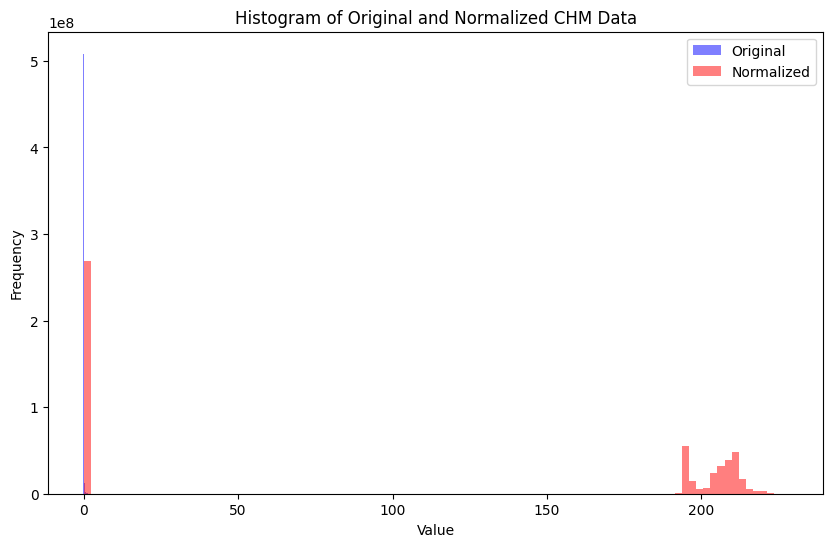

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(chm_data.flatten(), bins=100, color='blue', alpha=0.5, label='Original')
plt.hist(dsm.flatten(), bins=100, color='red', alpha=0.5, label='Normalized')
plt.title('Histogram of Original and Normalized CHM Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

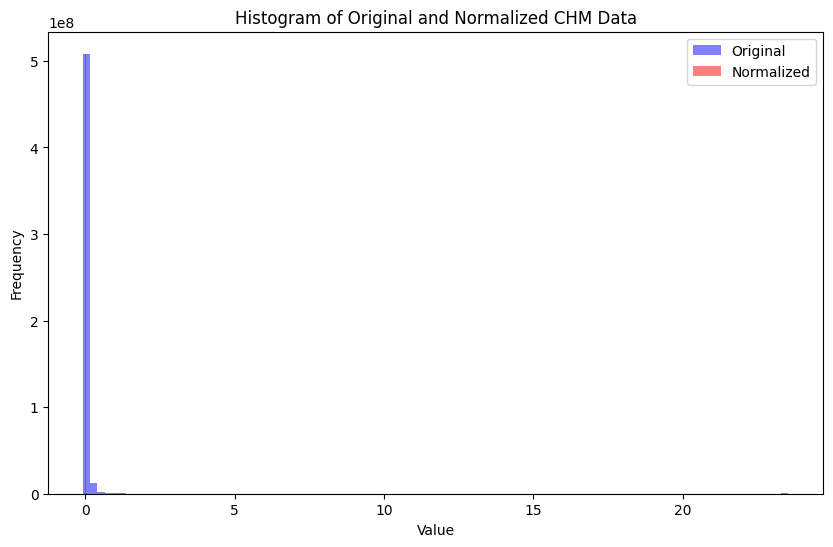

In [25]:
# Plot the original and normalized CHM data
plt.figure(figsize=(10, 6))
plt.hist(chm_data.flatten(), bins=100, color='blue', alpha=0.5, label='Original')
plt.hist(norm_chm_data.flatten(), bins=100, color='red', alpha=0.5, label='Normalized')
plt.title('Histogram of Original and Normalized CHM Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

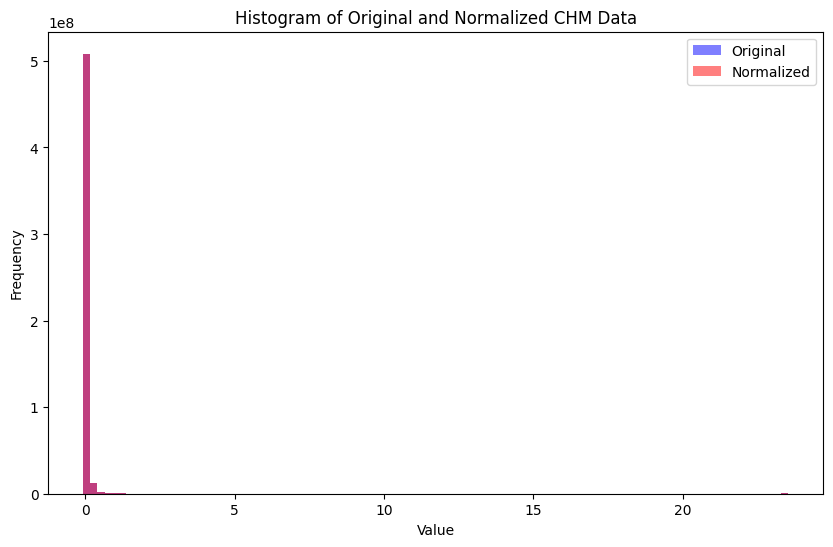

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(chm_data.flatten(), bins=100, color='blue', alpha=0.5, label='Original')
plt.hist(std_chm_data.flatten(), bins=100, color='red', alpha=0.5, label='Normalized')
plt.title('Histogram of Original and Normalized CHM Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

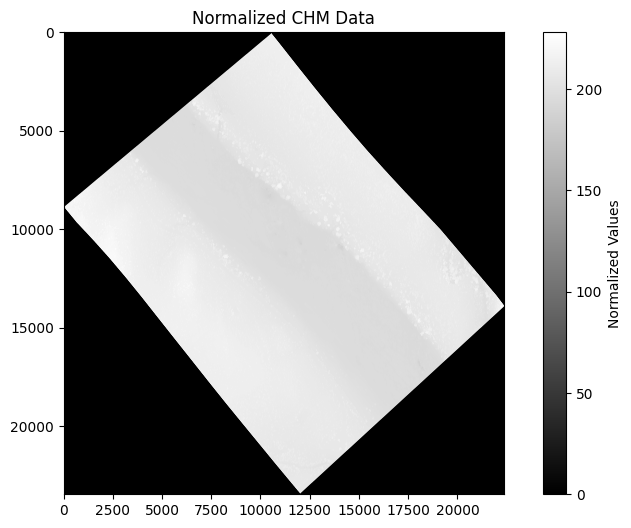

In [35]:
# Plot the normalized CHM data
plt.figure(figsize=(10, 6))
plt.imshow(dsm, cmap='gray')
plt.title('Normalized CHM Data')
plt.colorbar(label='Normalized Values')
plt.show()

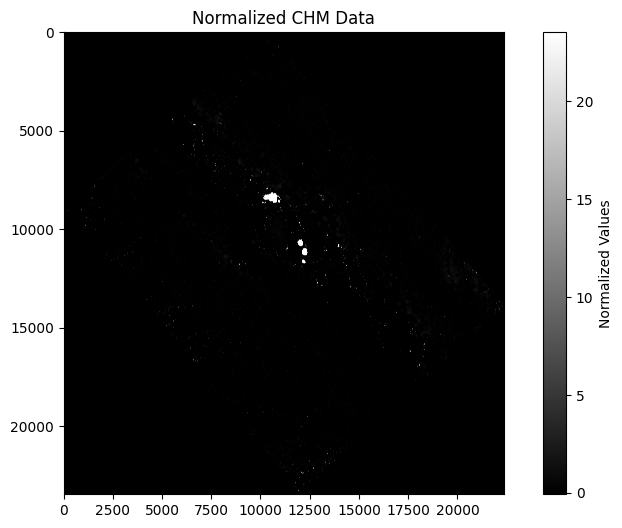

In [30]:
plt.figure(figsize=(10, 6))
plt.imshow(chm_data, cmap='gray')
plt.title('Normalized CHM Data')
plt.colorbar(label='Normalized Values')
plt.show()

In [ ]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalizes the pixel values of the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The normalized image.
    """
    normalized_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    logger.info(f'Normalized image shape: {normalized_image.shape}')
    return normalized_image

def convert_to_rgb(rgba_aligned):
    # Read the raster bands directly into numpy arrays.
    rgba_data = rgba_aligned.read()
    rgb_data = rgba_data[:3, :, :]
    rgb_data_hwc = np.transpose(rgb_data, (1, 2, 0))
    return rgb_data_hwc

In [ ]:
rgb_data_hwc = convert_to_rgb(rgba_clipped)
rgb = normalize_image(rgb_data_hwc)

In [ ]:
hyps_aligned.shape, dsm_aligned.shape, dtm_aligned.shape

In [ ]:
rgba_aligned.shape

In [ ]:
plt.imshow(rgb)
plt.show()

In [ ]:
with rasterio.open(image_path) as src:
        # Read the data and transpose the dimensions
        raster_data = src.read().transpose(1, 2, 0)

In [ ]:
def clip_gdf(gdf, bounds):
    clipped_gdf = gdf[
        (gdf.geometry.x > bounds.left) & 
        (gdf.geometry.x < bounds.right) &
        (gdf.geometry.y > bounds.bottom) &
        (gdf.geometry.y < bounds.top)
    ]
    logger.info(f"Original gdf: {gdf.shape}")
    logger.info(f"Clipped gdf: {clipped_gdf.shape}")
    logger.info(f"Species split: {clipped_gdf.Species.value_counts()}")
    return clipped_gdf

@utils.timer
def plot_raster(gdf, rasterimg, out_dir=None, fn=None, show=False, save=False):
    fig, ax = plt.subplots(figsize = (20,20))
    rasterio.plot.show(rasterimg, ax=ax)
    gdf.plot(column='Species',
                   categorical=True,
                   legend=True,
                   cmap="Set2",
                   ax=ax,
            aspect=1)
    ax.set_title("Letaba Points Subset")
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.pid):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    if show == True:
        rasterio.plot.show(rasterimg, ax=ax)
    if save == True:
        utils.save_plot(fig, f"{out_dir}preprocessed_{fn}.png")
        logger.info(f"Saved plot to {out_dir}preprocessed_{fn}.png")


def process_shp(clipped_gdf, buffer=10):
    gdf_copy = clipped_gdf.copy()
    gdf_copy['buffer'] = gdf_copy.buffer(buffer)
    return gdf_copy


def save_cropped_tifs(path_int_cr, pid, raster_type, label, out_image, out_meta):
    with rasterio.open(f"{path_int_cr}{pid}_{raster_type}_{label}.tif", "w", **out_meta) as dst:
        dst.write(out_image)

def crop_buffer(raster, polygon, path_pri, pid, raster_type, label):
    geojson_polygon = mapping(polygon)
    out_image, out_transform = mask(raster, [geojson_polygon], crop=True)
    out_meta = raster.meta.copy()
    out_meta.update({"height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform})
    save_cropped_tifs(path_pri, pid, raster_type, label, out_image, out_meta)

@utils.timer
def create_cropped_data(clipped_gdf, conf,
                     rgb_aligned, ms_aligned, dsm_clipped, dtm_clipped):
    gdf_copy = process_shp(clipped_gdf, buffer=conf.preprocess.crop_buffer)
    for _, row in gdf_copy.iterrows():
        crop_buffer(rgb_aligned, row.buffer, conf.data.path_int_cr, row.pid, 'rgba', row.Species)
        crop_buffer(ms_aligned, row.buffer, conf.data.path_int_cr, row.pid, 'hyps', row.Species)
        crop_buffer(dsm_clipped, row.buffer, conf.data.path_int_cr, row.pid, 'dsm', row.Species)
        crop_buffer(dtm_clipped, row.buffer, conf.data.path_int_cr, row.pid, 'dtm', row.Species)


@utils.timer
def main():
    conf = utils.load_config("base")
    imgs, gdf = load_data(conf)

    intersecting_box = get_bbox(imgs)
    target_bounds = intersecting_box.bounds
    
    rgba_clipped = clip_raster_to_bounds('rgba', conf.data.path_int_cl, imgs['rgba'], target_bounds)
    hyps_clipped = clip_raster_to_bounds('hyps', conf.data.path_int_cl, imgs['hyps'], target_bounds)
    dsm_clipped = clip_raster_to_bounds('dsm', conf.data.path_int_cl, imgs['dsm'], target_bounds)
    dtm_clipped = clip_raster_to_bounds('dtm', conf.data.path_int_cl, imgs['dtm'], target_bounds)

    rgba_aligned = align_rasters('rgba', conf.data.path_int_al, rgba_clipped, dsm_clipped)
    hyps_aligned = align_rasters('hyps', conf.data.path_int_al, hyps_clipped, dsm_clipped)

    clipped_gdf = clip_gdf(gdf, rgba_aligned.bounds)

    plot_raster(clipped_gdf, rgba_aligned, 
                out_dir=conf.data.path_rep, fn=conf.data.fn_rgba, show=False, save=True)
    plot_raster(clipped_gdf, hyps_aligned, 
                out_dir=conf.data.path_rep, fn=conf.data.fn_hyps, show=False, save=True)
    plot_raster(clipped_gdf, dsm_clipped, 
                out_dir=conf.data.path_rep, fn=conf.data.fn_dsm, show=False, save=True)
    plot_raster(clipped_gdf, dtm_clipped, 
                out_dir=conf.data.path_rep, fn=conf.data.fn_dtm, show=False, save=True)

    create_cropped_data(clipped_gdf, conf,
                     rgba_aligned, hyps_aligned, dsm_clipped, dtm_clipped)
    # # gdf_copy['buffer_wkt'] = gdf_copy['buffer'].to_wkt()
    # gdf_copy = gdf_copy.drop(columns=['geometry'])
    # logger.info(f"{conf.data.path_int_points}{conf.data.fn_shp_combined}")
    # # gdf_copy.to_parquet(f"{conf.data.path_int_points}{conf.data.fn_shp_combined}")
    # gdf_copy.to_file(f"{conf.data.path_int_points}{conf.data.fn_shp_combined}", 
    #                  driver='ESRI Shapefile')#, geometry='geometry')


if __name__ == "__main__":
    main()